In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42)  


In [67]:
layer_num=3
hidden_num=64
sym='symetry'

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [68]:
def potential(x,k):
    poten=1/2*k*x**2
    return poten

In [69]:
def new_potential(x,k):
    poten=-1/2*k*x**2+1/20*x**4-1/5000*x**6+1/1000000*x**8
    return poten

In [70]:
def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [71]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
para_mult=2
La=-5*para_mult
Lb =5*para_mult
L=Lb-La  # domain length
N = 1000*para_mult   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
k=4
en_num=20
epoch=3000
lr=0.01

model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,k)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
real_en= torch.linalg.eigvalsh(A)
print('initial real_en check:')
print(real_en[:en_num])


initial real_en check:
tensor([ 0.9998,  3.0000,  5.0000,  6.9994,  8.9991, 10.9990, 12.9988, 14.9984,
        16.9980, 18.9975, 20.9971, 22.9966, 24.9961, 26.9954, 28.9947, 30.9938,
        32.9933, 34.9926, 36.9915, 38.9905], device='cuda:0')


In [72]:
# initial real_en check:
# tensor([ 0.9972,  2.9926,  4.9965,  7.0260,  9.0970, 11.2181, 13.3982, 15.6421,
#         17.9539, 20.3339, 22.7840, 25.3028, 27.8923, 30.5494, 33.2754, 36.0674,
#         38.9264, 41.8494, 44.8371, 47.8871], device='cuda:0')

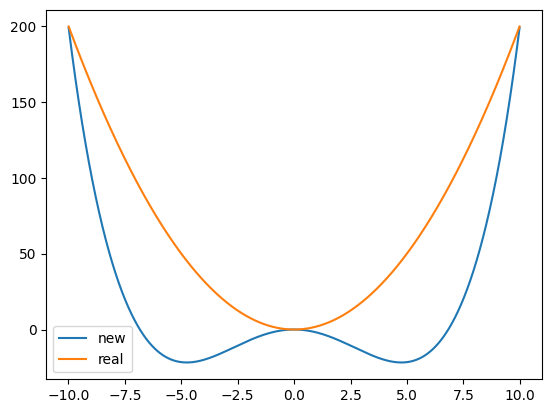

: 

In [ ]:
real_poten=potential(grid.cpu().detach().numpy(),k)
poten1=new_potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy(),poten1,label='new')
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.legend()
plt.show()